<a href="https://colab.research.google.com/github/gustavochavesferreira/tp1_algoritmos2/blob/main/LZW_implementation_with_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Instalações provisórias para debug

In [61]:
!pip install graphviz
!apt-get install graphviz -y

from graphviz import Digraph

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# Implementação da árvore de prefixos (Trie)

# Implementando a versão final da compressão LZW, empregando árvores Trie como dicionários para consulta e inserção:

In [62]:
%%writefile lzw.py

import os
from typing import Tuple
import struct

import time
import tracemalloc
import json
import argparse
import json
import sys



class CompactTrieNode:
  def __init__(self, binary_string: str = "", value: str = "", is_leaf: bool = False) -> None:
    self.children = [None, None]
    self.is_leaf = is_leaf
    self.binary_string = binary_string
    self.value = value
    self.unique_id = id(self)  # Temporário

class CompactTrie:
  def __init__(self) -> None:
    self.root = None

  def get_common_prefix_length(self, key1: str, key2: str) -> int:
    i = 0
    while i < min(len(key1), len(key2)) and key1[i] == key2[i]:
        i += 1
    return i

  def search(self, key: str) -> CompactTrieNode:
    current_node = self.root

    if(current_node == None):
      return None

    while True:
      if((current_node.binary_string == key) and (current_node.is_leaf == True)):
        return current_node

      common_prefix_length = self.get_common_prefix_length(current_node.binary_string, key)

      if(common_prefix_length == len(current_node.binary_string)):

        key = key[common_prefix_length:]

        if current_node.children[int(key[0])] == None:
          return None

        current_node = current_node.children[int(key[0])]
      else:
        return None

  def insert(self, key: str, value: str) -> None:
    # Caso em que não tínhamos raiz
    if(self.root == None):
      self.root = CompactTrieNode(key, value, True)
      return

    else:
      current_node = self.root

      while True:
        # Achei, posso parar
        if(current_node.binary_string == key):
          current_node.is_leaf = True
          return

        common_prefix_length = self.get_common_prefix_length(current_node.binary_string, key)

        # Sobrou parte da key ainda, com certeza
        if (common_prefix_length == len(current_node.binary_string)):
          key = key[common_prefix_length:]

          if current_node.children[int(key[0])] == None:
            current_node.children[int(key[0])] = CompactTrieNode(key, value, True)
            return

          current_node = current_node.children[int(key[0])]

        # Achei onde vou ter que criar novo nó para inserir
        else:
          key = key[common_prefix_length:]

          if(current_node.is_leaf == True):
            old_suffix_node = CompactTrieNode(current_node.binary_string[common_prefix_length:], current_node.value, True)
          else:
            old_suffix_node = CompactTrieNode(current_node.binary_string[common_prefix_length:], current_node.value)

          old_suffix_node.children[0] = current_node.children[0]
          old_suffix_node.children[1] = current_node.children[1]

          current_node.binary_string = current_node.binary_string[:common_prefix_length]

          if(len(key) > 0):
            key_suffix_node = CompactTrieNode(key, value, True)
            current_node.is_leaf = False
            current_node.children[int(key_suffix_node.binary_string[0])] = key_suffix_node
            current_node.children[int(old_suffix_node.binary_string[0])] = old_suffix_node
          else:
            current_node.value = value
            current_node.is_leaf = True
            current_node.children = [None, None]
            current_node.children[int(old_suffix_node.binary_string[0])] = old_suffix_node
          return

  def delete_key(self, key: str) -> None:
    if(self.search(key) == None):
      return

    current_node = self.root
    last_node = self.root

    if(current_node.binary_string == key):
      if(current_node.children[0] == None and current_node.children[1] == None):
        self.root = None
        return
      elif(current_node.children[0] != None and current_node.children[1] != None):
        current_node.is_leaf = False
        return
      else:
        valid_child = 0 if current_node.children[0] != None else 1
        current_node.children[valid_child].binary_string = current_node.binary_string + current_node.children[valid_child].binary_string
        self.root = current_node.children[valid_child]
        return

    while True:
      if((current_node.binary_string == key) and (current_node.is_leaf == True)):
        if((current_node.children[0] != None) and (current_node.children[1] != None)):
          current_node.is_leaf = False
        elif((current_node.children[0] == None) and (current_node.children[1] == None)):
          last_node.children[int(current_node.binary_string[0])] = None

          if(last_node.is_leaf == False):
            last_node_other_child = 0 if current_node.binary_string[0] == '1' else 1

            if(last_node.children[last_node_other_child] != None):
              last_node.binary_string += last_node.children[last_node_other_child].binary_string
              last_node.value = last_node.children[last_node_other_child].value
              if(last_node.children[last_node_other_child].is_leaf):
                last_node.is_leaf = True
              last_node.children = last_node.children[last_node_other_child].children
        else:
          valid_child = 0 if current_node.children[0] != None else 1
          current_node.children[valid_child].binary_string = current_node.binary_string + current_node.children[valid_child].binary_string
          last_node.children[int(current_node.children[valid_child].binary_string[0])] = current_node.children[valid_child]
        return

      common_prefix_length = self.get_common_prefix_length(current_node.binary_string, key)
      key = key[common_prefix_length:]
      last_node = current_node
      current_node = current_node.children[int(key[0])]

  # Temporário
  def visualize(self, filename="compact_trie"):
      dot = Digraph(comment="Compact Trie")

      def add_nodes_edges(node, parent_label=None):
          if node is None:
              return

          new_node_binary_string = node.binary_string
          new_node_binary_string = new_node_binary_string.replace("0", "a")
          new_node_binary_string = new_node_binary_string.replace("1", "b")

          node_label = f"{new_node_binary_string}_{node.unique_id}"

          display_label = f"{new_node_binary_string}"
          if(node.is_leaf):
            display_label  += f"\\nValue: {node.value}"

          dot.node(node_label, display_label, shape='circle', color='black', fontcolor='red' if node.is_leaf else 'blue')

          if parent_label:
              dot.edge(parent_label, node_label)
          if node.children[0] is not None:
              add_nodes_edges(node.children[0], node_label)
          if node.children[1] is not None:
              add_nodes_edges(node.children[1], node_label)

      if self.root is not None:
          add_nodes_edges(self.root)

      dot.render(filename, format="png", cleanup=True)
      print(f"Compact trie saved as {filename}.png")

# Para debug
def binary_to_chars(binary_string):
    # Ensure the binary string length is a multiple of 8 (since each character is 8 bits)
    if len(binary_string) % 8 != 0:
        raise ValueError("Binary string length must be a multiple of 8.")

    # Split the binary string into chunks of 8 bits
    chars = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]

    # Convert each 8-bit binary chunk to its corresponding character
    result = ''.join(chr(int(char, 2)) for char in chars)

    return result

# # Função para converter um conjunto de bytes em um '.txt'
# def write_txt_file(decoded_bytes, output_file):
#     decoded_string = ''.join([chr(byte) for byte in decoded_bytes])
#     with open(output_file, 'w', encoding='utf-8') as file:
#         file.write(decoded_string)

def write_txt_file(decoded_bytes, output_file):
    with open(output_file, 'wb') as file:
        file.write(bytes(decoded_bytes))


# Função para converter um conjunto de bytes em um '.bmp' ou '.pgm'
def write_image_file(decoded_bytes, output_file):
    with open(output_file, 'wb') as file:
        file.write(bytes(decoded_bytes))

def write_audio_file(decoded_bytes, output_file):
    with open(output_file, 'wb') as file:
        file.write(bytes(decoded_bytes))

# Função para remover zeros à esquerda em uma string binárias
def remove_leading_zeros(binary_str):
  return binary_str.lstrip('0') or '0'


class TrieLZW:
  # Atributos para armazenar as estatísticas
  def __init__(self):
      self.stats = {
          'compression_ratio_over_time': [],
          'dictionary_size_over_time': [],
          'execution_time': 0,
          'memory_usage': 0
      }

  # Realiza a compressão LZW do arquivo passado como parâmetro
  def compress(self, file_path: str="") -> Tuple[str, str]:

    # Iniciar rastreamento de tempo e memória
    start_time = time.time()
    tracemalloc.start()

    # Utilizando a Trie Compacta Binária como dicionário no algoritmo
    dictionary = CompactTrie()

    # Inicializando todas as chaves de 00000000 até 11111111 no dicionário, com respectivos valores sendo a própria chave
    for num in range(256):
      byte_num = format(num, '08b')
      dictionary.insert(byte_num, byte_num)

    dict_size = 256 # O dicionário começa com todos os símbolos ASCII
    num_bits_values = 9 # Começaremos usando 9 bits para representar códigos a partir de agora
    next_dict_size_limit = 2 * 256 # Os 9 bits serão suficientes para representar códigos de 000000000 (0) até 111111111 (511)

    # Inicializando variáveis utilizadas pela compressão LZW
    string = ""
    compressed_data = []

    # Aplicando a compressão LZW, considerando cada byte do arquivo orignal como um símbolo de entrada
    try:
      count = 256
      with open(file_path, "rb") as file:
        while (byte := file.read(1)):
          symbol = bin(int.from_bytes(byte, "big"))[2:].zfill(8)

          string_plus_symbol = string + symbol

          if dictionary.search(string_plus_symbol) != None:
              string = string_plus_symbol
          else:
            # Caso em que o dicionário tem tamanho dinâmico
            if(dict_size == next_dict_size_limit):
                num_bits_values += 1
                next_dict_size_limit *= 2

            current_string_formatted_binary_value = dictionary.search(string).value.zfill(num_bits_values)
            compressed_data.append(current_string_formatted_binary_value)
            new_key_value = bin(dict_size)[2:].zfill(num_bits_values)
            dictionary.insert(string_plus_symbol, new_key_value)
            dict_size += 1
            string = symbol


            # Atualizar estatísticas
            self.stats['dictionary_size_over_time'].append(dict_size)

            # Calcular o tamanho comprimido atual (em bits)
            compressed_size_bits = sum(len(code) for code in compressed_data)

            # Calcular o tamanho original processado até agora (em bits)
            original_size_bits = (len(compressed_data) + 1) * 8  # Cada símbolo original tem 8 bits

            # Calcular a taxa de compressão atual
            compression_ratio = compressed_size_bits / original_size_bits
            self.stats['compression_ratio_over_time'].append(compression_ratio)


        if(dictionary.search(string) != None):
          current_string_formatted_binary_value = dictionary.search(string).value.zfill(num_bits_values)
          compressed_data.append(current_string_formatted_binary_value)

    # Tratando erros que podem ocorrer na abertura de um arquivo
    except FileNotFoundError as e:
      print(f"Arquivo não encontrado -> {e}")
    except IOError as e:
      print(f"Erro de I/O -> {e}")
    except Exception as e:
      print(f"Um erro ocorreu: {e}")

    # Salvando o nome do arquivo original e sua extensão para que o arquivo de compressão possa ser salvo
    base_file_name = os.path.basename(file_path)
    file_name_without_ext, file_extension = os.path.splitext(base_file_name)

    # Nome do arquivo comprimido
    compressed_file_name = f"compressed_{file_name_without_ext}.bin"
    file_name = file_name_without_ext  # Add this line
    # # Salvando o nome do arquivo original e sua extensão para que o arquivo de compressão possa ser salvo
    # file_name, file_extension = os.path.splitext(file_path)

    with open(f"compressed_{file_name}.bin", "wb") as file:
      # Convertendo os códigos para uma única string
      final_concat_string_data = ''.join(compressed_data)

      # Verificando se algum padding deverá ser adicionado para que tenhamos um número inteiro de bytes no arquivo comprimido
      padding_size = (8 - len(final_concat_string_data) % 8) % 8
      final_concat_string_data = '0' * padding_size + final_concat_string_data

      # Adicionando uma flag, no arquivo comprimido, para representar o tamanho do padding que foi adicionado
      file.write(bytes([padding_size]))

      # Convertendo a string de dados comprimidos para bytes e escrevendo no arquivo comprimido final
      bits = []
      for char in final_concat_string_data:
        bits.append(1 if char == '1' else 0)
      byte = 0
      bit_count = 0
      for bit in bits:
        byte = (byte << 1) | bit
        bit_count += 1
        if bit_count == 8:
          file.write(bytes([byte]))
          byte = 0
          bit_count = 0

      # Finalizar rastreamento de tempo e memória
      end_time = time.time()
      self.stats['execution_time'] = end_time - start_time

      current_memory, peak_memory = tracemalloc.get_traced_memory()
      self.stats['memory_usage'] = peak_memory / 1024  # Converter para KB
      tracemalloc.stop()

      return [file_name_without_ext, file_extension]

  # Realiza a descompressão LZW do arquivo passado como parâmetro
  def decompress(self, file_path: str="", original_file_name: str="", original_file_extension: str="") -> None:

    # Iniciar rastreamento de tempo e memória
    start_time = time.time()
    tracemalloc.start()

    # Utilizando a Trie Compacta Binária como dicionário no algoritmo
    dictionary = CompactTrie()

    # Inicializando todas as chaves de 0, 1, 10, 11, 100, ... até 11111111 no dicionário (sem padding), com respectivos valores sendo a própria chave (com padding)
    for num in range(256):
      numeric_key = bin(num)[2:]
      numeric_key_8bit_value = format(num, '08b')
      dictionary.insert(numeric_key, numeric_key_8bit_value)

    dict_size = 256 # O dicionário começa com todos os número de 0 até 255, cada um representando um símbolo ASCII
    decompression_size = 9 # Começaremos puxando 9 bits do arquivo comprimido por vez
    next_size_limit = 2 * 256 # Os 9 bits serão suficientes até que o tamanho do dicionário atinja 512 elementos

    # Abrindo o arquivo já comprimido e convertendo seus bytes em uma única string
    compressed_data = ""
    try:
      with open(file_path, "rb") as file:
        file_data = file.read()
        compressed_data = ''.join(format(byte, '08b') for byte in file_data)
    # Tratando erros que podem ocorrer na abertura de um arquivo
    except FileNotFoundError:
      print(f"File not found: {file_path}")
    except IOError as e:
      print(f"Error reading the file: {e}")
    except Exception as e:
      print(f"An unexpected error occurred: {e}")

    # Retirando os bits de padding do arquivo comprimido
    padding_size = int(compressed_data[:8], 2)
    compressed_data = compressed_data[(8 + padding_size):]

    # Inicializando as variáveis que serão empregadas posteriormente
    string = compressed_data[:decompression_size]
    string = string[-8:]

    compressed_data = compressed_data[decompression_size:]
    decompressed_data = [string]

    # Aplicando a descompressão LZW
    while(len(compressed_data) > 0):
        # Caso em que o dicionário tem tamanho dinâmico
        if(dict_size == next_size_limit - 1):
          decompression_size += 1
          next_size_limit *= 2

        k = compressed_data[:decompression_size]
        compressed_data = compressed_data[decompression_size:]

        k = remove_leading_zeros(k)

        if dictionary.search(k) != None:
          entry = dictionary.search(k).value
        else:
          new_value_entry_concat = string[:8]
          entry = string + new_value_entry_concat

        decompressed_data.append(entry)
        new_key = bin(dict_size)[2:] if dict_size != 0 else '0'
        dictionary.insert(new_key, string + entry[:8])
        dict_size += 1

        string = entry

    decompressed_concat_string = ''.join(decompressed_data)

    # Checando algum possível erro que possa ter ocorrido na descompressão (o tamanho do arquivo final deve ser um múltiplo de 8)
    if len(decompressed_concat_string) % 8 != 0:
      raise ValueError("O arquivo descomprimido não tem um número inteiro de bytes!")

    # Transformando a string binárias em bytes individuais
    byte_chunks = [decompressed_concat_string[i:i+8] for i in range(0, len(decompressed_concat_string), 8)]
    bytes_ = [int(chunk, 2) for chunk in byte_chunks]

    # Convert integers to their ASCII characters
    ascii_characters = [chr(i) for i in bytes_]
    # Join characters into a string (optional)
    ascii_string = ''.join(ascii_characters)


    # Nome do arquivo descomprimido
    decompressed_file_name = f"decompressed_{original_file_name}{original_file_extension}"



    # Gerando o arquivo inicial
    switch = {
        '.txt': write_txt_file,
        '.bmp': write_image_file,
        '.bin': write_image_file,
        '.wav': write_audio_file,
        '.pgm': write_image_file,

    }
    handler = switch.get(original_file_extension)
    if handler:
        handler(bytes_, decompressed_file_name)
    else:
        print("Unsupported file type.")


    # Finalizar rastreamento de tempo e memória
    end_time = time.time()
    self.stats['execution_time'] = end_time - start_time

    current_memory, peak_memory = tracemalloc.get_traced_memory()
    self.stats['memory_usage'] = peak_memory / 1024  # Converter para KB
    tracemalloc.stop()







def main():
    parser = argparse.ArgumentParser(description='Compress or decompress files using LZW algorithm with Compact Trie.')
    subparsers = parser.add_subparsers(dest='command', help='Available commands: compress, decompress')

    # Parser for the 'compress' command
    compress_parser = subparsers.add_parser('compress', help='Compress a file')
    compress_parser.add_argument('input_file', type=str, help='Path to the input file to compress')
    compress_parser.add_argument('output_file', type=str, help='Path to the output compressed file')
    compress_parser.add_argument('--max-bits', type=int, help='Maximum number of bits (default: 12)', default=12)
    compress_parser.add_argument('--stats-file', type=str, help='Path to save compression stats', default=None)

    # Parser for the 'decompress' command
    decompress_parser = subparsers.add_parser('decompress', help='Decompress a file')
    decompress_parser.add_argument('input_file', type=str, help='Path to the input compressed file')
    decompress_parser.add_argument('output_file', type=str, help='Path to the output decompressed file')
    decompress_parser.add_argument('--max-bits', type=int, help='Maximum number of bits (default: 12)', default=12)
    decompress_parser.add_argument('--stats-file', type=str, help='Path to save decompression stats', default=None)

    args = parser.parse_args()

    if args.command == 'compress':
        compress(args.input_file, args.output_file, args.stats_file, args.max_bits)
    elif args.command == 'decompress':
        decompress(args.input_file, args.output_file, args.stats_file, args.max_bits)
    else:
        parser.print_help()

def compress(input_file, output_file, stats_file=None, max_bits=12):
    trie_lzw = TrieLZW()

    # Executa a compressão
    trie_lzw.compress(input_file)

    # Obter o nome base do arquivo de entrada
    input_base_name = os.path.splitext(os.path.basename(input_file))[0]
    compressed_file_name = f"compressed_{input_base_name}.bin"

    if os.path.exists(compressed_file_name):
        os.rename(compressed_file_name, output_file)
    else:
        print(f"Error: Compressed file {compressed_file_name} not found.")
        sys.exit(1)

    # Salva as estatísticas, se especificado
    if stats_file:
        with open(stats_file, 'w') as f:
            json.dump(trie_lzw.stats, f, indent=4)
        print(f"Compression stats saved to {stats_file}")

    print(f"Compression completed: {output_file}")

def decompress(input_file, output_file, stats_file=None, max_bits=12):
    trie_lzw = TrieLZW()

    # Obter o nome base e extensão do arquivo de saída
    output_base_name, output_extension = os.path.splitext(os.path.basename(output_file))
    original_file_name = output_base_name.replace('decompressed_', '')

    # Executa a descompressão
    trie_lzw.decompress(input_file, original_file_name, output_extension)

    # Nome do arquivo descomprimido gerado pelo método
    decompressed_file_name = f"decompressed_{original_file_name}{output_extension}"

    if os.path.exists(decompressed_file_name):
        os.rename(decompressed_file_name, output_file)
    else:
        print(f"Error: Decompressed file {decompressed_file_name} not found.")
        sys.exit(1)

    # Salva as estatísticas, se especificado
    if stats_file:
        with open(stats_file, 'w') as f:
            json.dump(trie_lzw.stats, f, indent=4)
        print(f"Decompression stats saved to {stats_file}")

    print(f"Decompression completed: {output_file}")

if __name__ == '__main__':
    main()

Overwriting lzw.py


In [63]:
!python lzw.py compress tests/small_text.txt tests/small_text_compressed.bin --stats-file compress_stats_small_text.json

Arquivo não encontrado -> [Errno 2] No such file or directory: 'tests/small_text.txt'
Traceback (most recent call last):
  File "/content/lzw.py", line 557, in <module>
    main()
  File "/content/lzw.py", line 499, in main
    compress(args.input_file, args.output_file, args.stats_file, args.max_bits)
  File "/content/lzw.py", line 516, in compress
    os.rename(compressed_file_name, output_file)
FileNotFoundError: [Errno 2] No such file or directory: 'compressed_small_text.bin' -> 'tests/small_text_compressed.bin'


In [64]:
!python lzw.py decompress tests/small_text_compressed.bin tests/small_text_decompressed.txt --max-bits 16 --stats-file decompress_stats_small_text.json

File not found: tests/small_text_compressed.bin
Traceback (most recent call last):
  File "/content/lzw.py", line 557, in <module>
    main()
  File "/content/lzw.py", line 501, in main
    decompress(args.input_file, args.output_file, args.stats_file, args.max_bits)
  File "/content/lzw.py", line 537, in decompress
    trie_lzw.decompress(input_file, original_file_name, output_extension)
  File "/content/lzw.py", line 392, in decompress
    padding_size = int(compressed_data[:8], 2)
ValueError: invalid literal for int() with base 2: ''


In [65]:
def are_files_identical(file1, file2):
    """
    Compare two files byte by byte to check if they are identical.
    """
    try:
        with open(file1, "rb") as f1, open(file2, "rb") as f2:
            while True:
                chunk1 = f1.read(4096)  # Read in chunks of 4 KB
                chunk2 = f2.read(4096)
                if chunk1 != chunk2:  # Compare the current chunks
                    return False
                if not chunk1:  # End of file reached
                    return True
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return False

In [66]:
!rmdir /content/tests/compressed_tests
!rm /content/tests/*



rmdir: failed to remove '/content/tests/compressed_tests': No such file or directory
rm: cannot remove '/content/tests/*': No such file or directory


In [67]:
import os
import requests

# Cria a pasta 'tests' se não existir
folder_name = "tests"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# URLs das imagens para download
urls = [
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/baboon.pgm",
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/cameraman.pgm",
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/lena512.pgm",
    "https://github.com/juliogdomingues/computacao_visual/raw/refs/heads/main/TP1/imagens/unequal.pgm"
]

# Baixa as imagens para a pasta 'tests'
initial_files_set = set()
for url in urls:
    filename = url.split("/")[-1]
    destination_path = os.path.join(folder_name, filename)
    print(f"Baixando {filename}...")
    response = requests.get(url)
    with open(destination_path, "wb") as file:
        file.write(response.content)
    print(f"{filename} salvo com sucesso!")
    initial_files_set.add(filename)

Baixando baboon.pgm...
baboon.pgm salvo com sucesso!
Baixando cameraman.pgm...
cameraman.pgm salvo com sucesso!
Baixando lena512.pgm...
lena512.pgm salvo com sucesso!
Baixando unequal.pgm...
unequal.pgm salvo com sucesso!


In [68]:
# Após o processamento, deleta os arquivos não originais
for file in os.listdir(folder_name):
    if file not in initial_files_set:
        os.remove(os.path.join(folder_name, file))

print(f"Arquivos restantes na pasta '{folder_name}': {os.listdir(folder_name)}")

Arquivos restantes na pasta 'tests': ['cameraman.pgm', 'unequal.pgm', 'baboon.pgm', 'lena512.pgm']


Arquivo com extensão não suportada encontrado e será ignorado: ufmg_57kb.jpg
Arquivo com extensão não suportada encontrado e será ignorado: ufmg_14kb.jpeg
Arquivo com extensão não suportada encontrado e será ignorado: notebook_1mb.tiff
Arquivo com extensão não suportada encontrado e será ignorado: lorem_5kb.docx
Arquivo com extensão não suportada encontrado e será ignorado: logoufmg_3kb.png
Arquivo comprimido já existe: test_files/imagemhomog_30kb.bmp.lzw. Pulando a compressão deste arquivo.
Arquivo comprimido já existe: test_files/textorepetido_27kb.txt.lzw. Pulando a compressão deste arquivo.
Arquivo comprimido já existe: test_files/cameraman.pgm.lzw. Pulando a compressão deste arquivo.
Arquivo comprimido já existe: test_files/lorem_5kb.txt.lzw. Pulando a compressão deste arquivo.
Arquivo comprimido já existe: test_files/unequal.pgm.lzw. Pulando a compressão deste arquivo.
Arquivo comprimido já existe: test_files/smallbin_10kb.bin.lzw. Pulando a compressão deste arquivo.
Arquivo comp

,File_Name,File_Type,Compression_Ratio,Dictionary_Size,Compression_Time(s),Memory_Usage(KB)
0,imagemhomog_30kb.bmp,Imagem,0.017735,706.0,14.249600,392.954102
1,textorepetido_27kb.txt,Texto,0.055704,1441.0,5.594268,798.951172
2,cameraman.pgm,Imagem,0.901592,33767.0,68.536767,26881.277344
3,lorem_5kb.txt,Texto,0.504188,2174.0,0.603423,1516.446289
4,unequal.pgm,Imagem,0.405148,36626.0,98.514788,27301.987305
5,smallbin_10kb.bin,Binário,1.453027,9799.0,4.946986,8119.297852
6,small_text_compressed.bin,Binário,3.000000,NaN,0.006895,144.887695
7,CantinaBand3_132kb.wav,Áudio,0.991771,69581.0,310.710465,56175.182617


Dados de Descompressão:


,File_Name,File_Type,Decompression_Time(s)
0,imagemhomog_30kb.bmp,Imagem,0.089742
1,textorepetido_27kb.txt,Texto,0.169627
2,cameraman.pgm,Imagem,5.866575
3,lorem_5kb.txt,Texto,0.427574
4,unequal.pgm,Imagem,5.266500
5,smallbin_10kb.bin,Binário,0.926233
6,small_text_compressed.bin,Binário,0.006635
7,CantinaBand3_132kb.wav,Áudio,13.067423


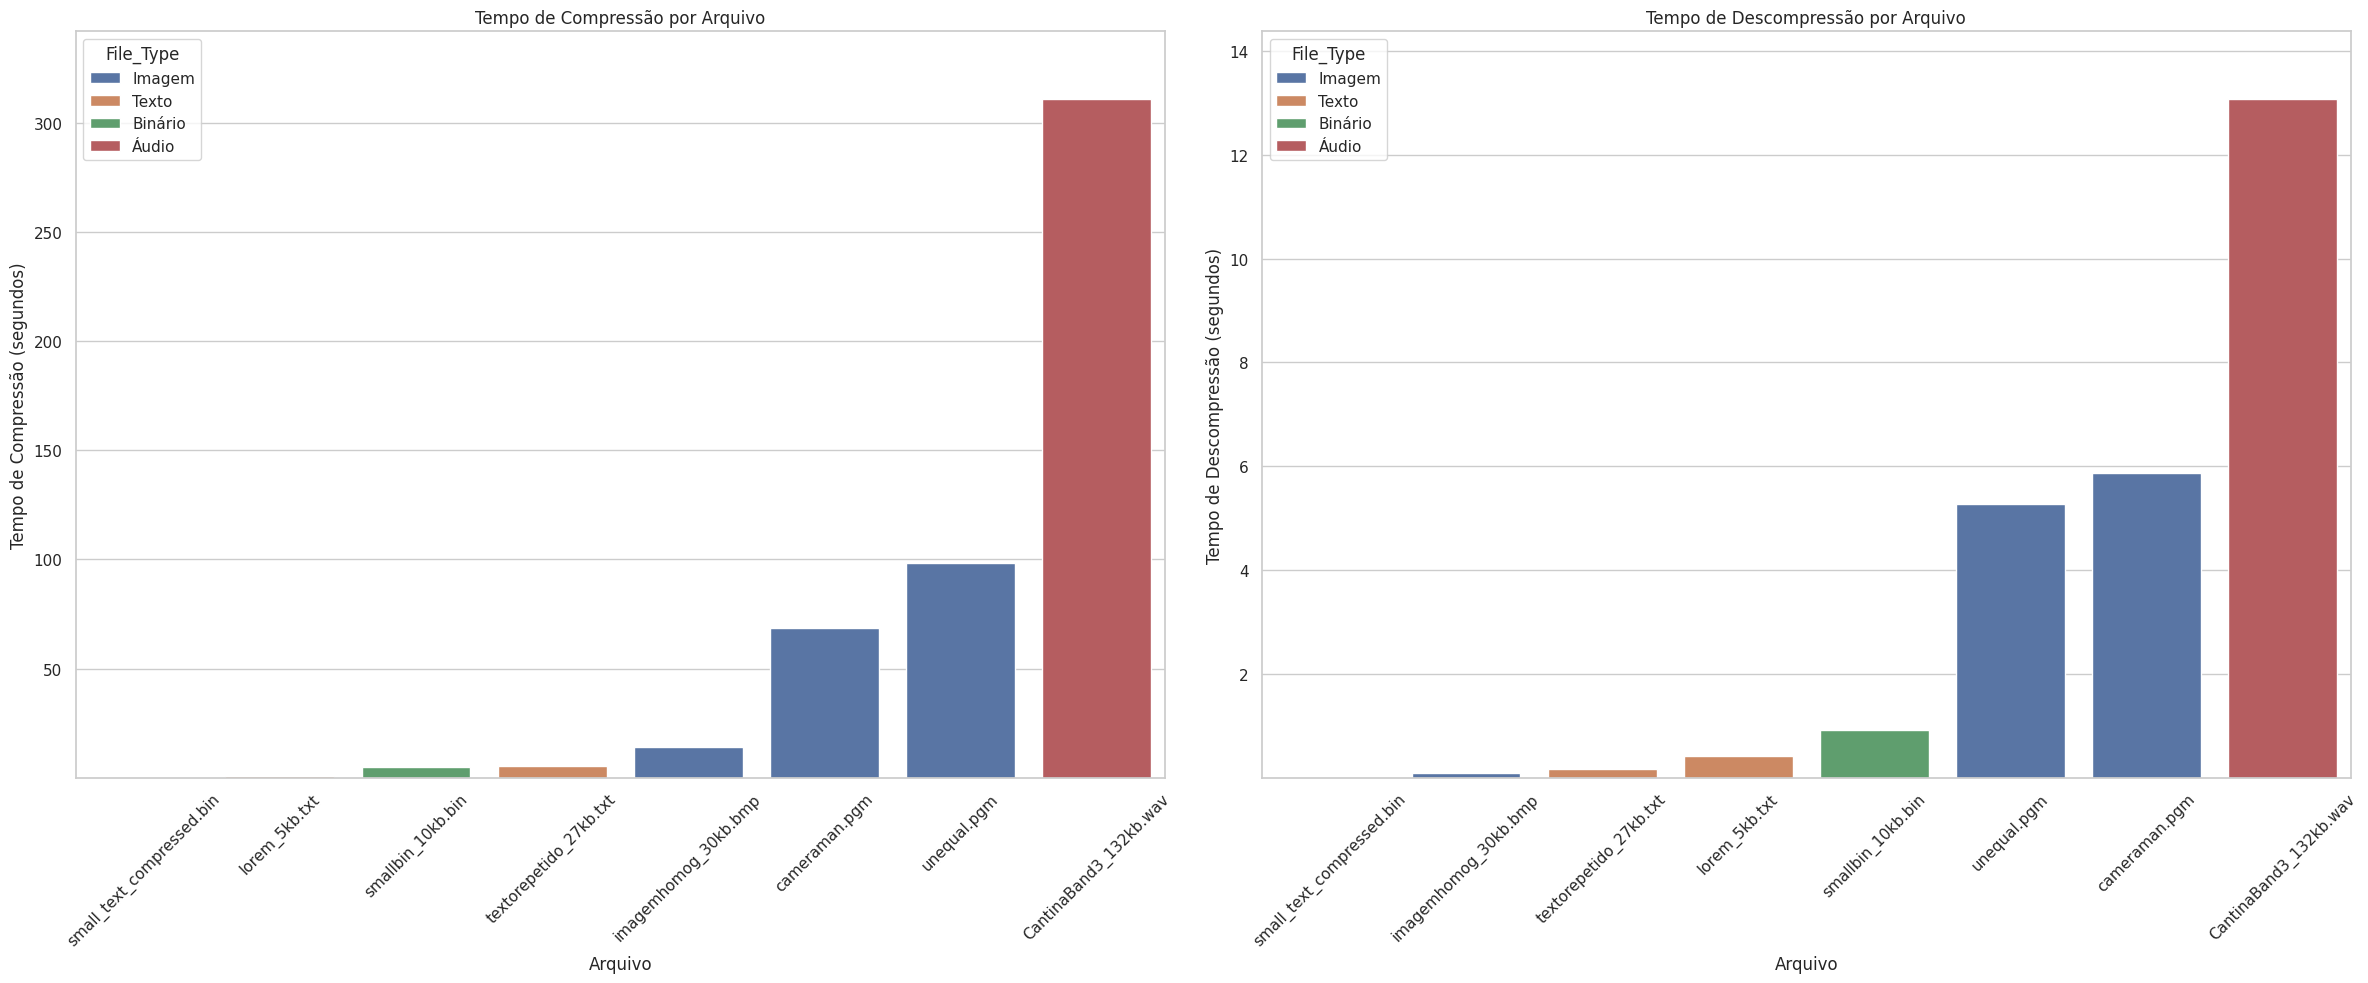

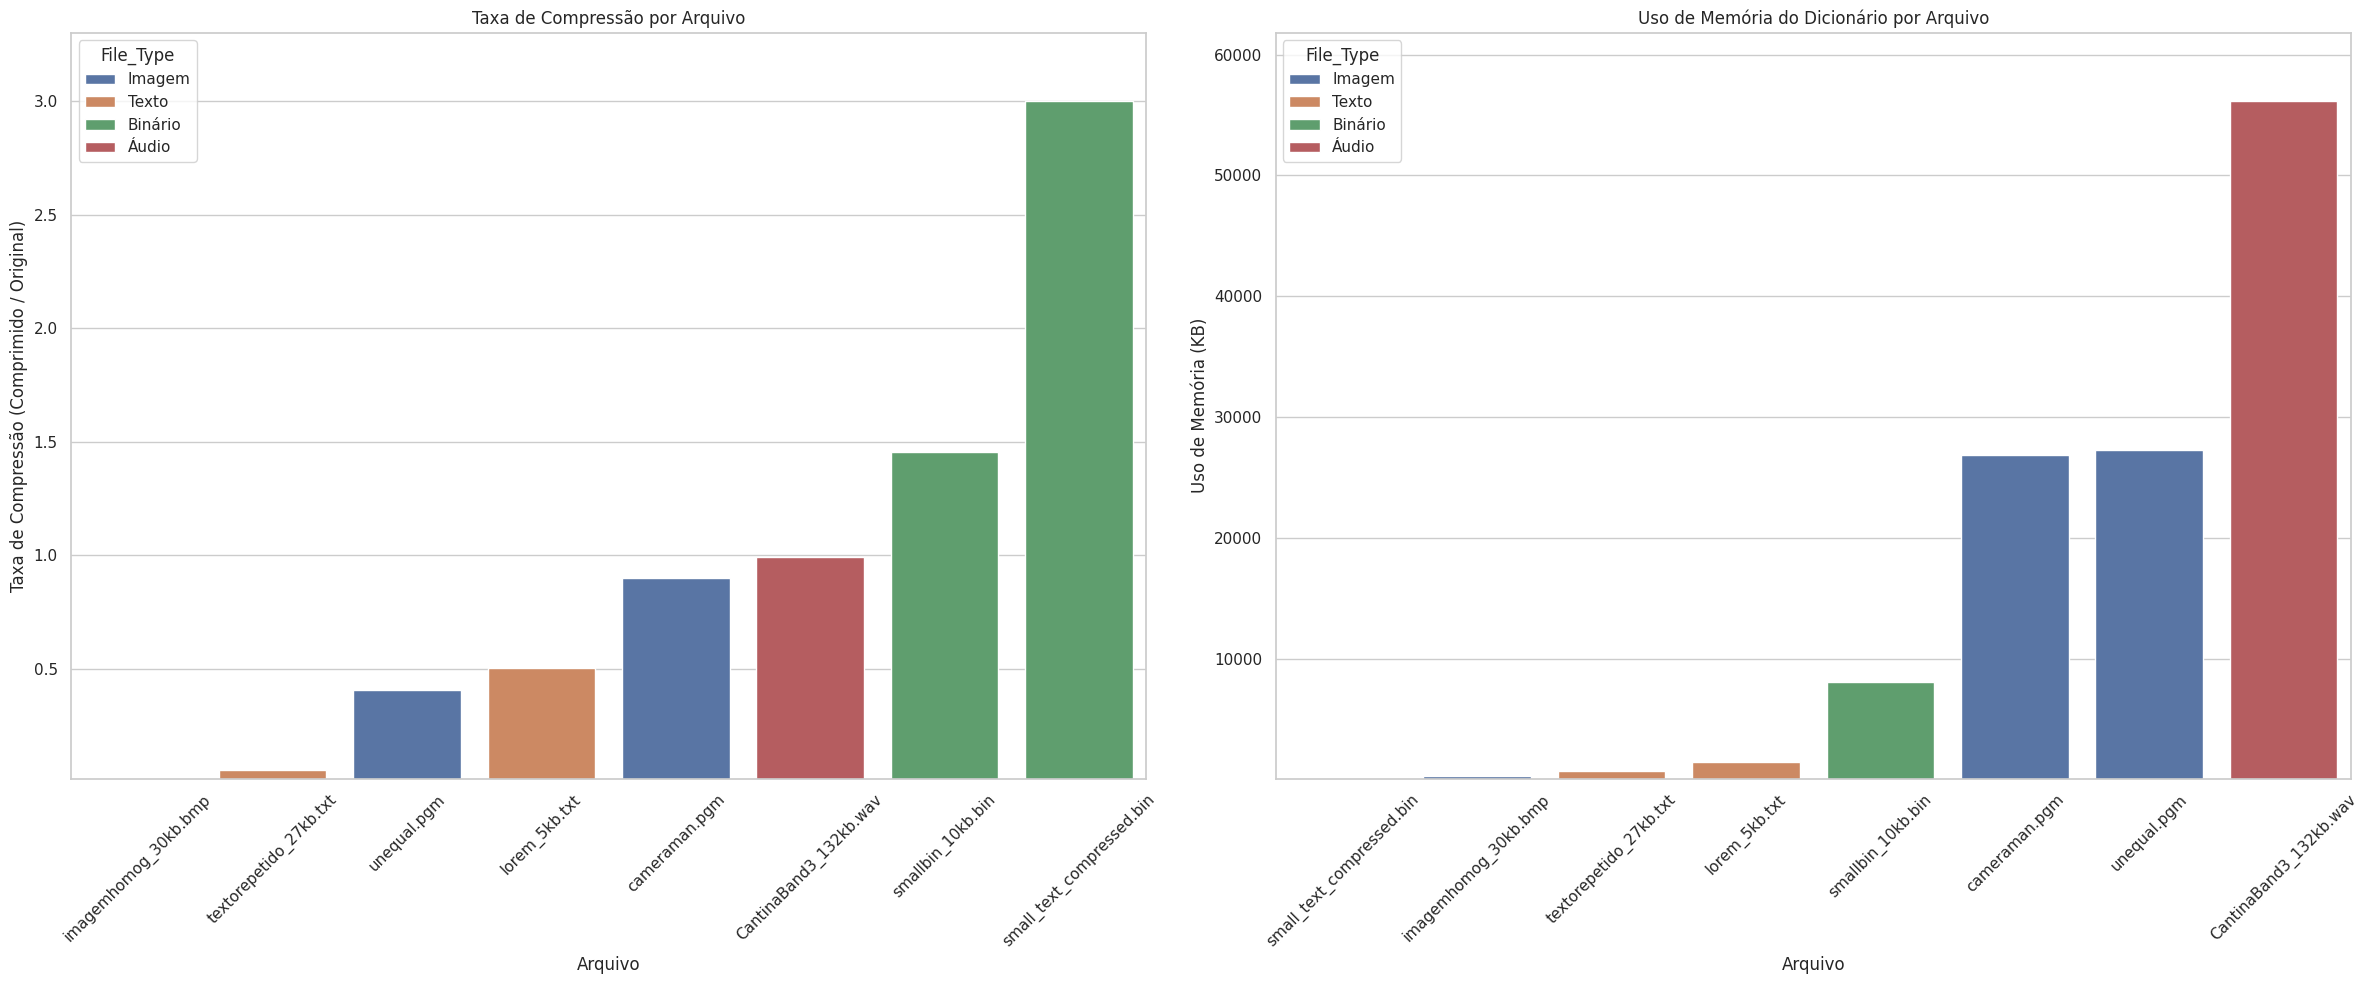

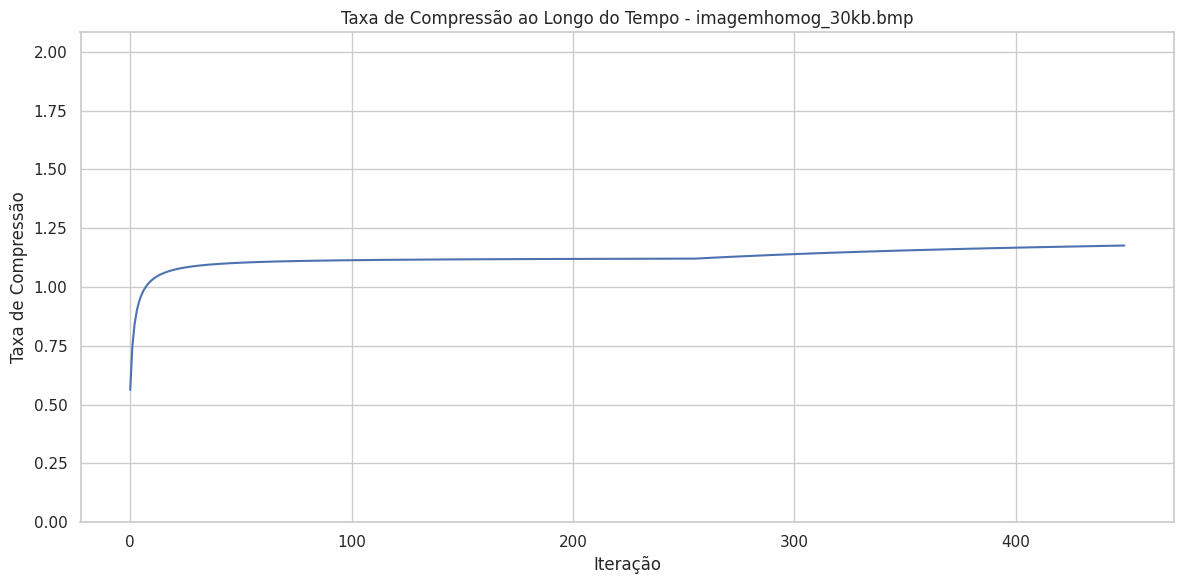

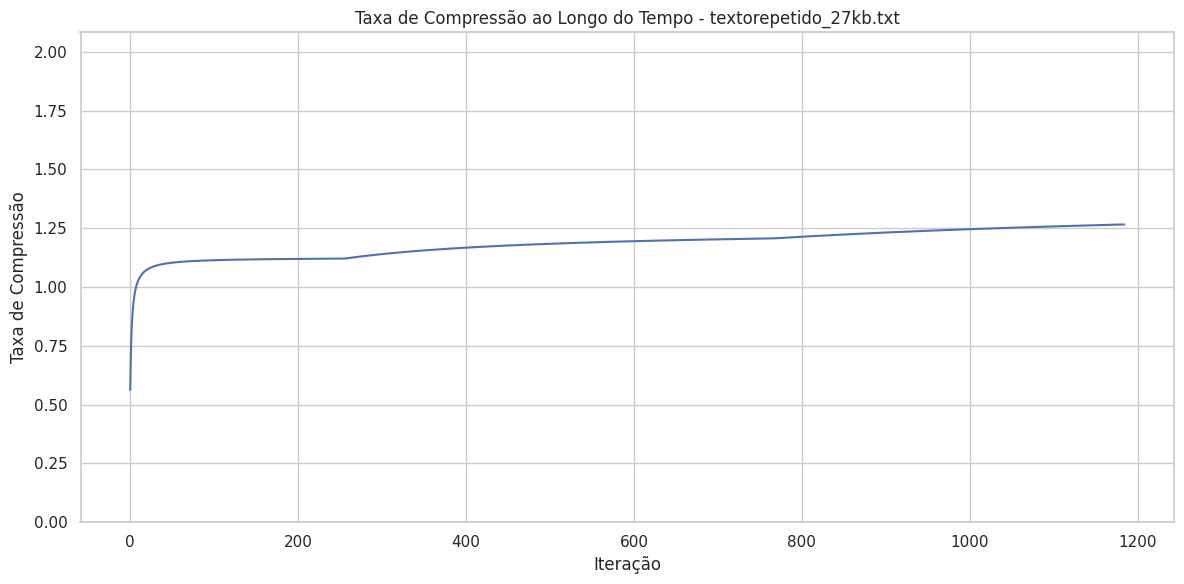

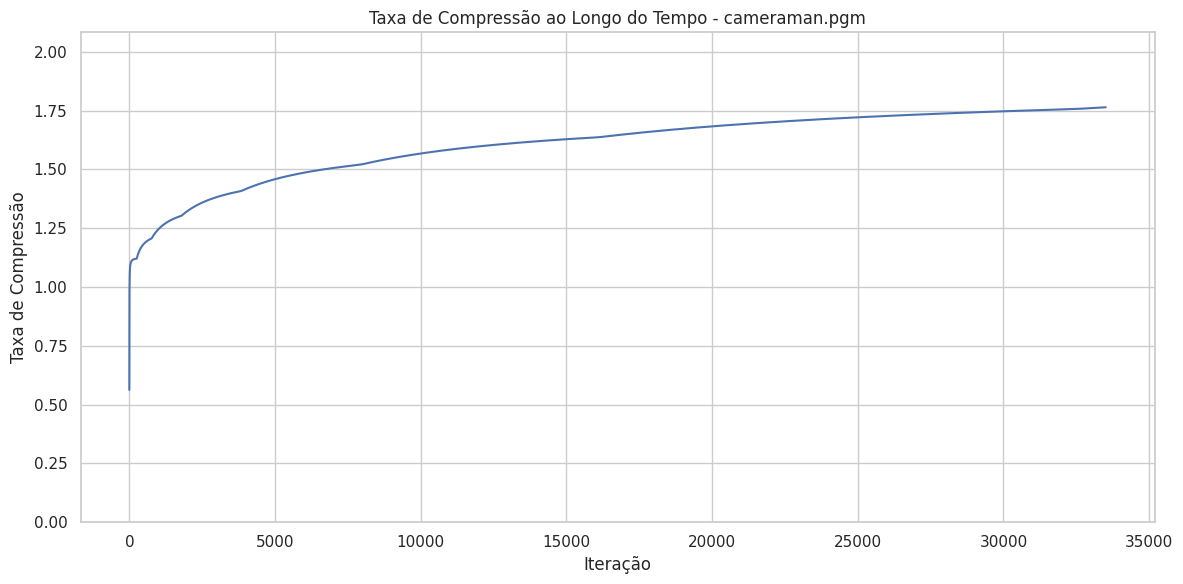

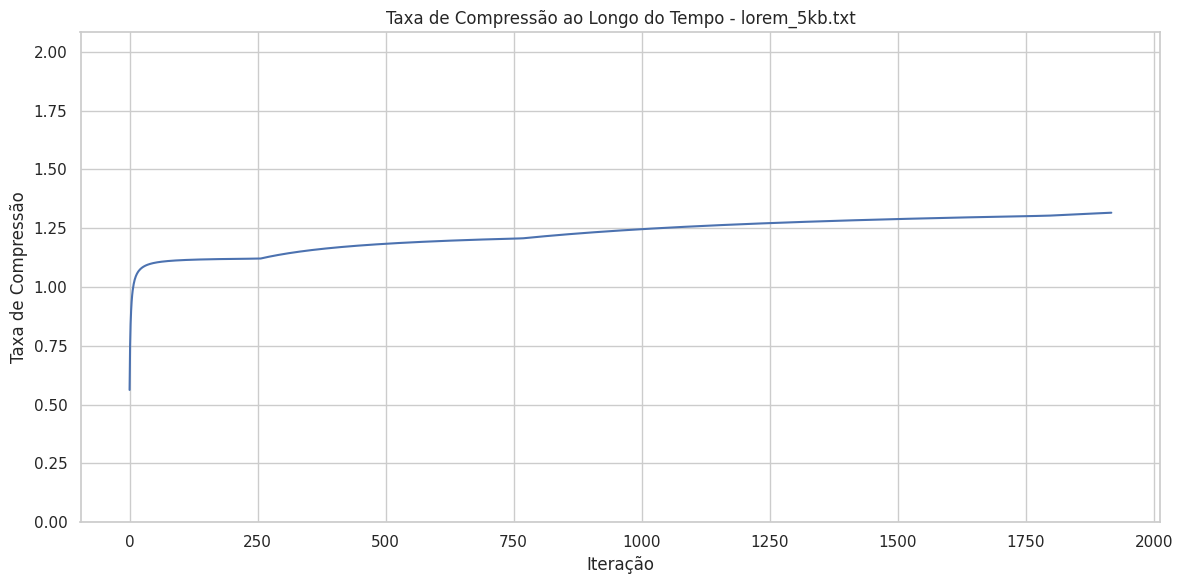

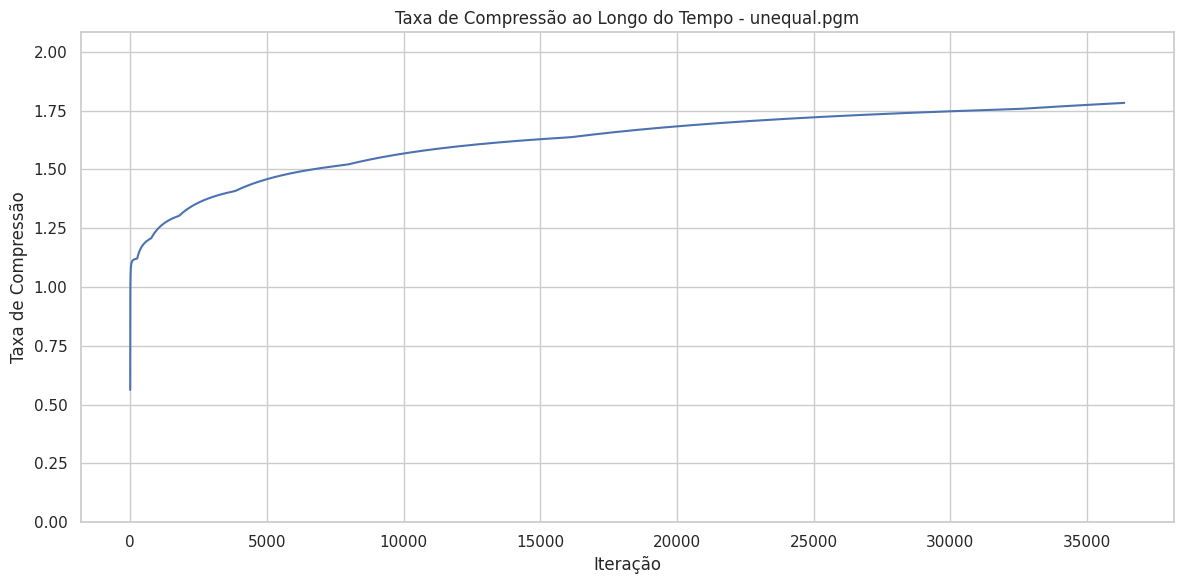

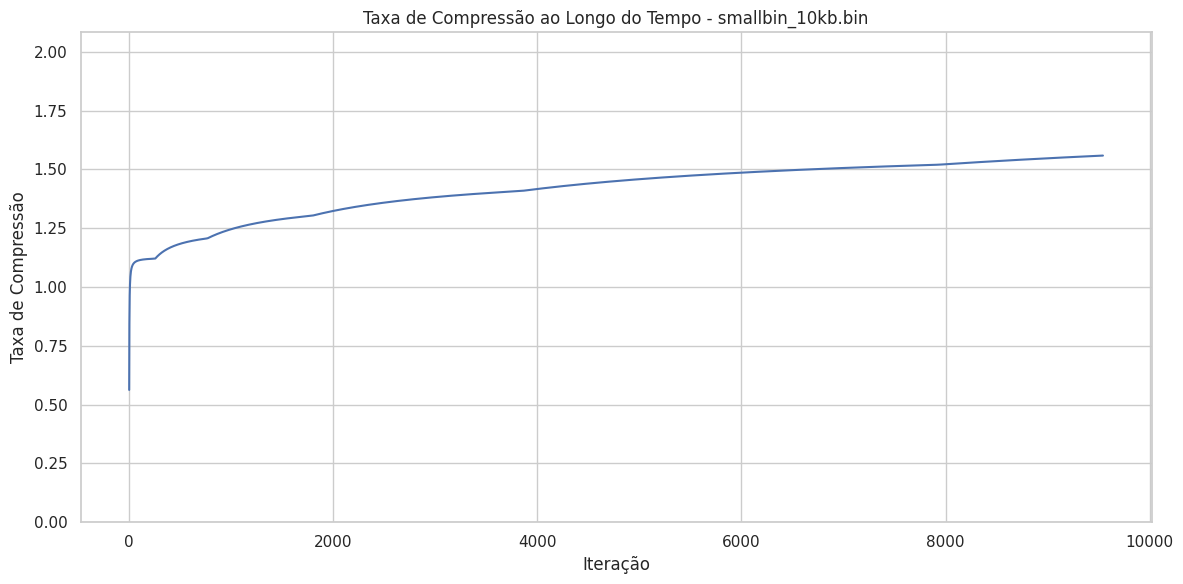

Sem dados de taxa de compressão ao longo do tempo para small_text_compressed.bin


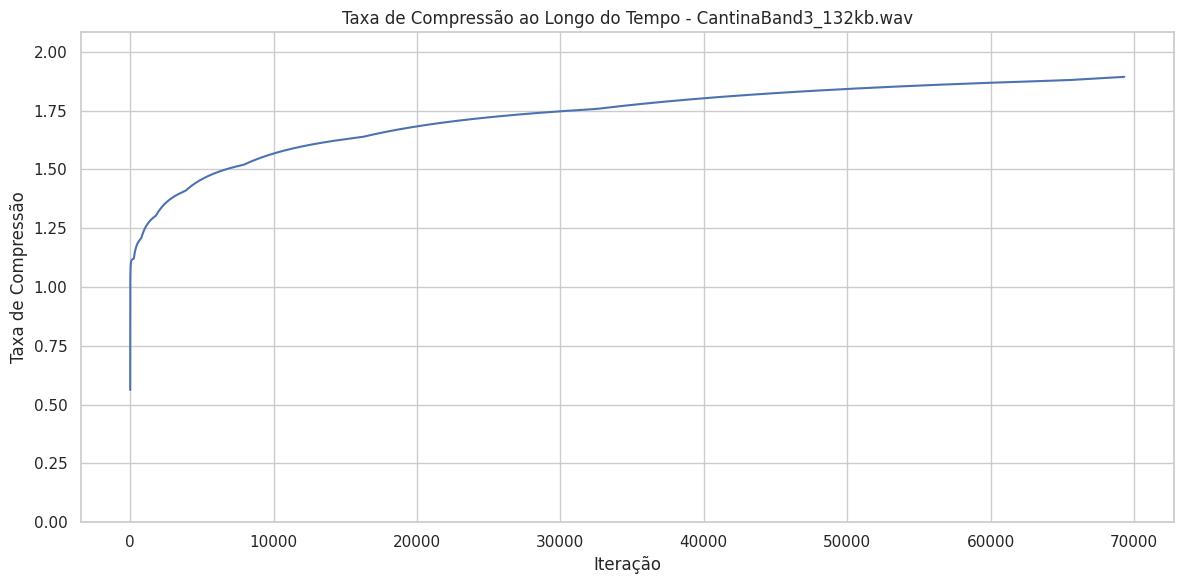

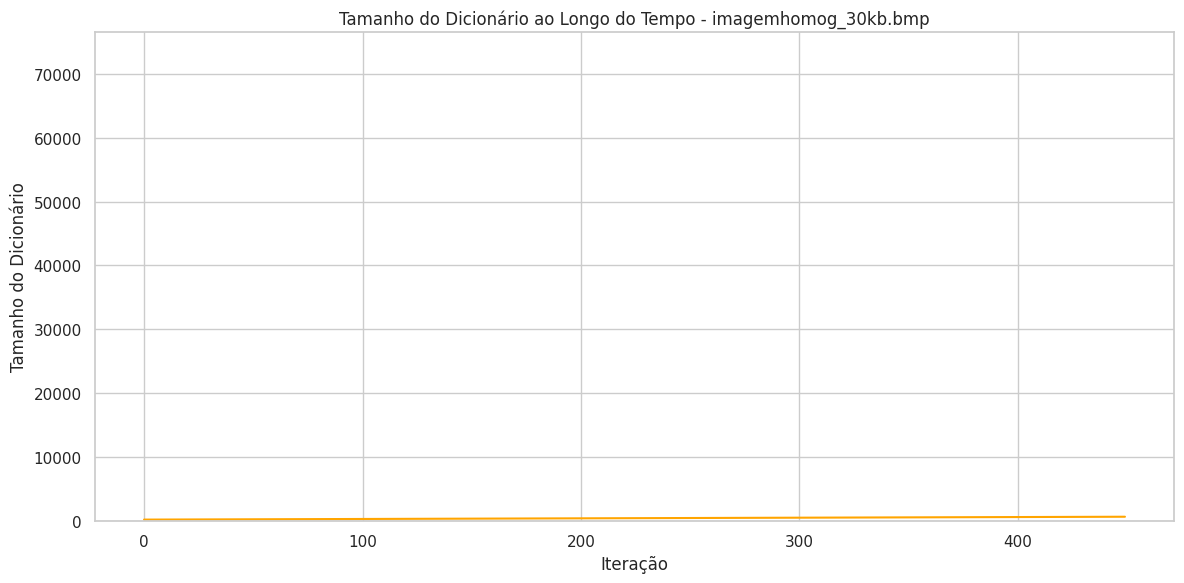

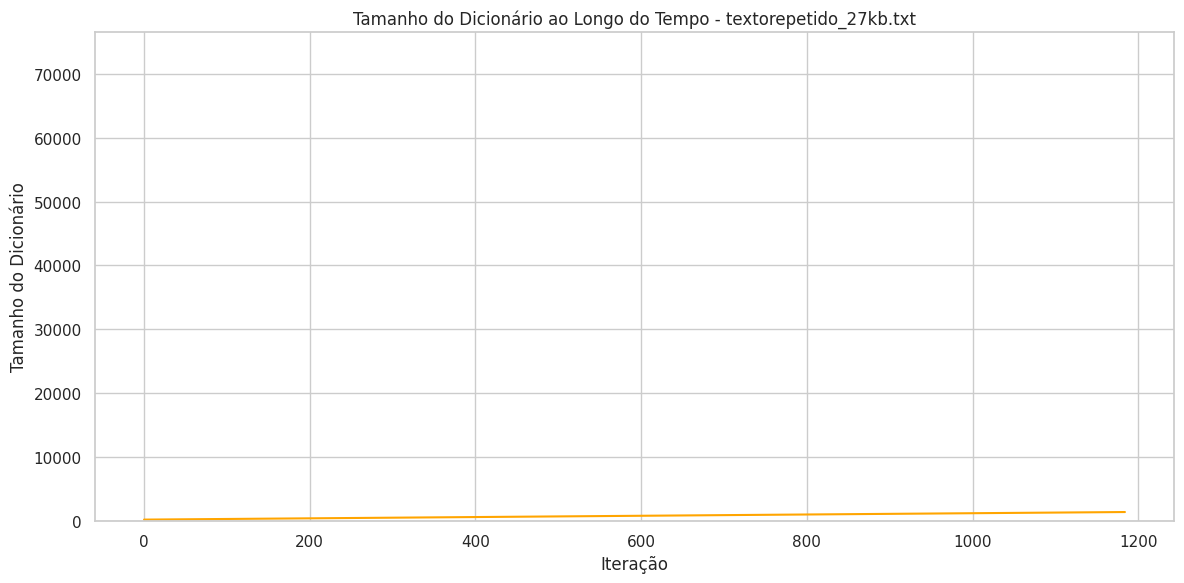

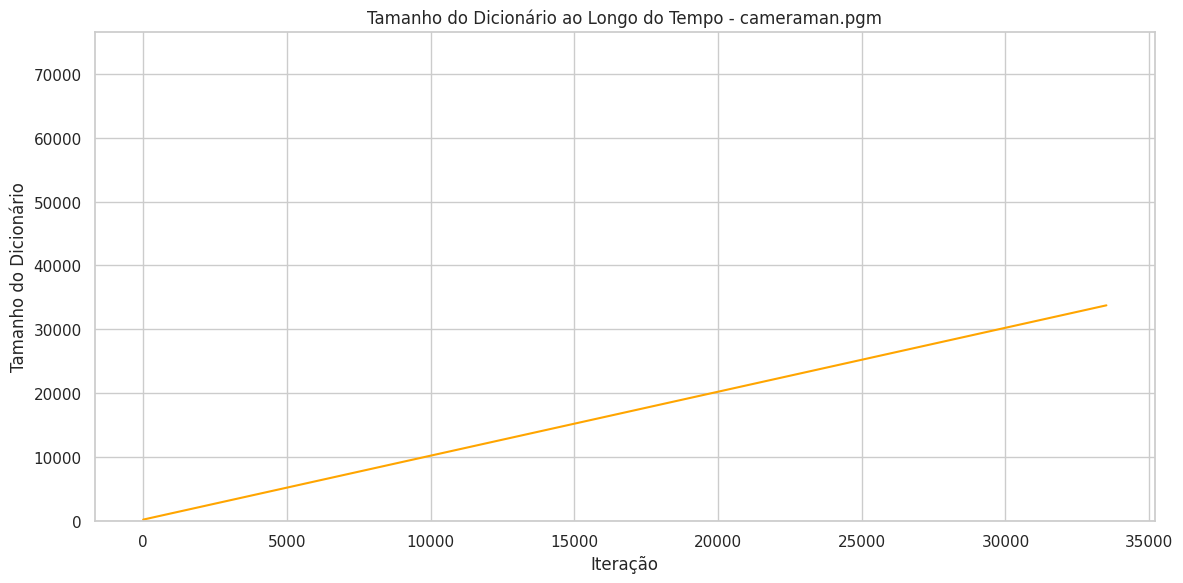

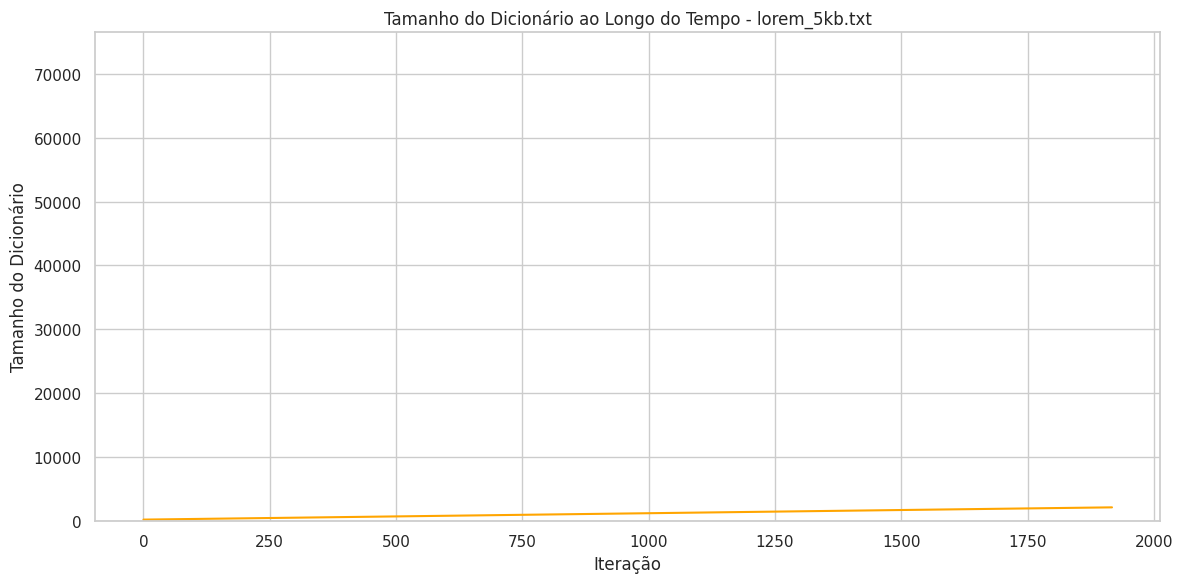

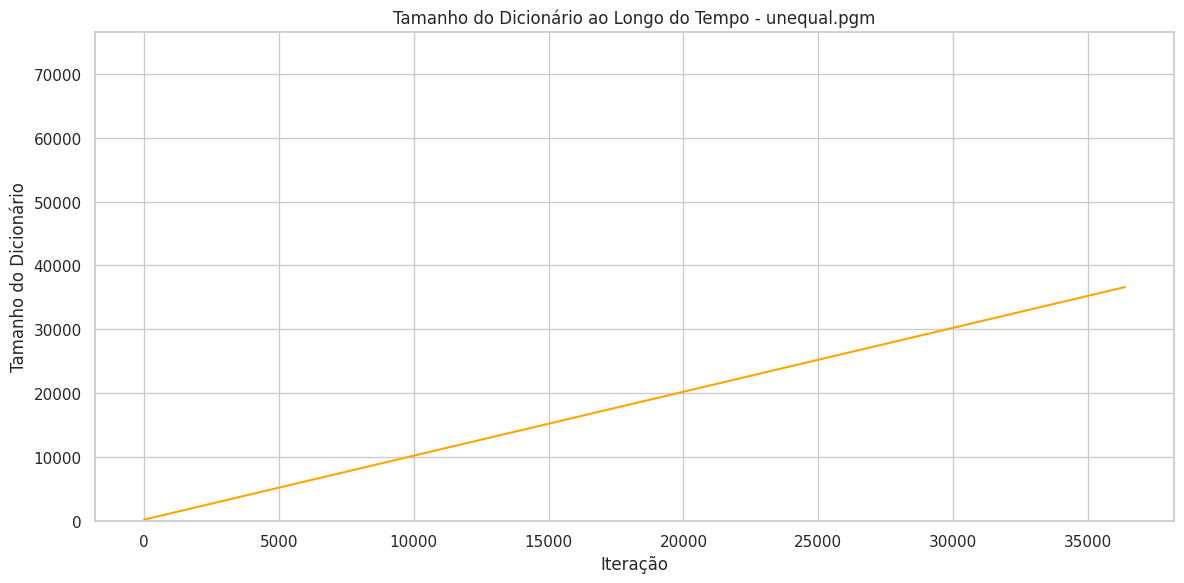

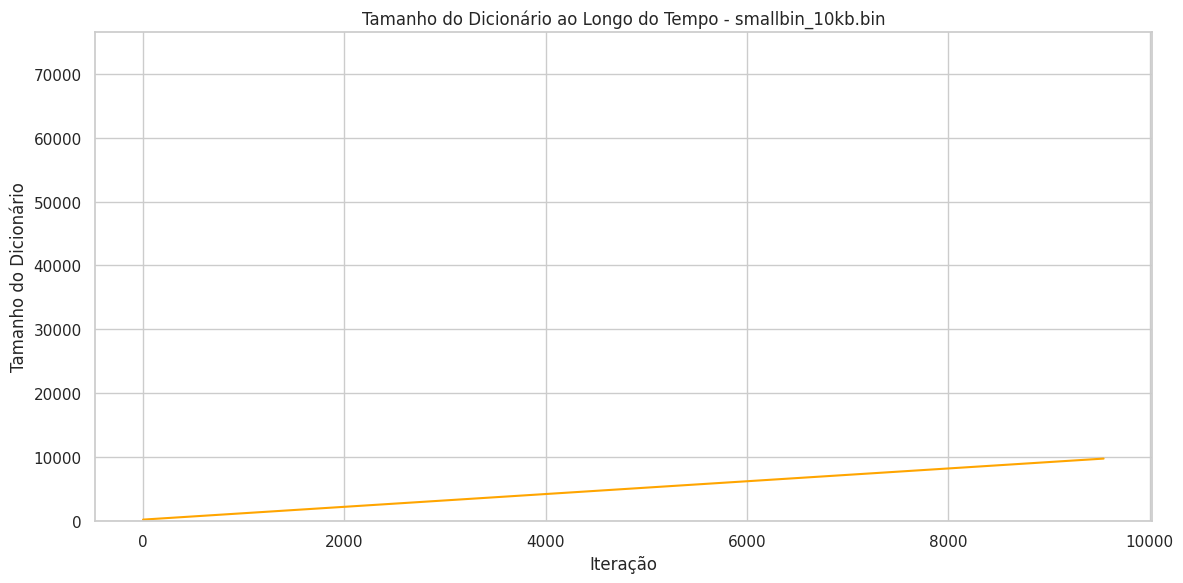

Sem dados de tamanho do dicionário ao longo do tempo para small_text_compressed.bin


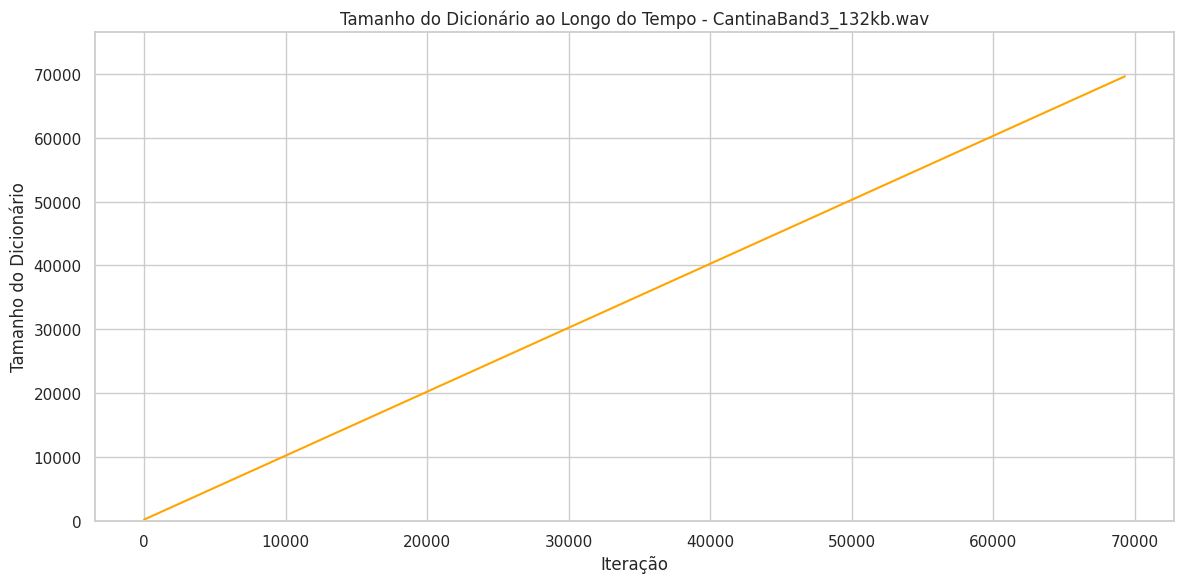

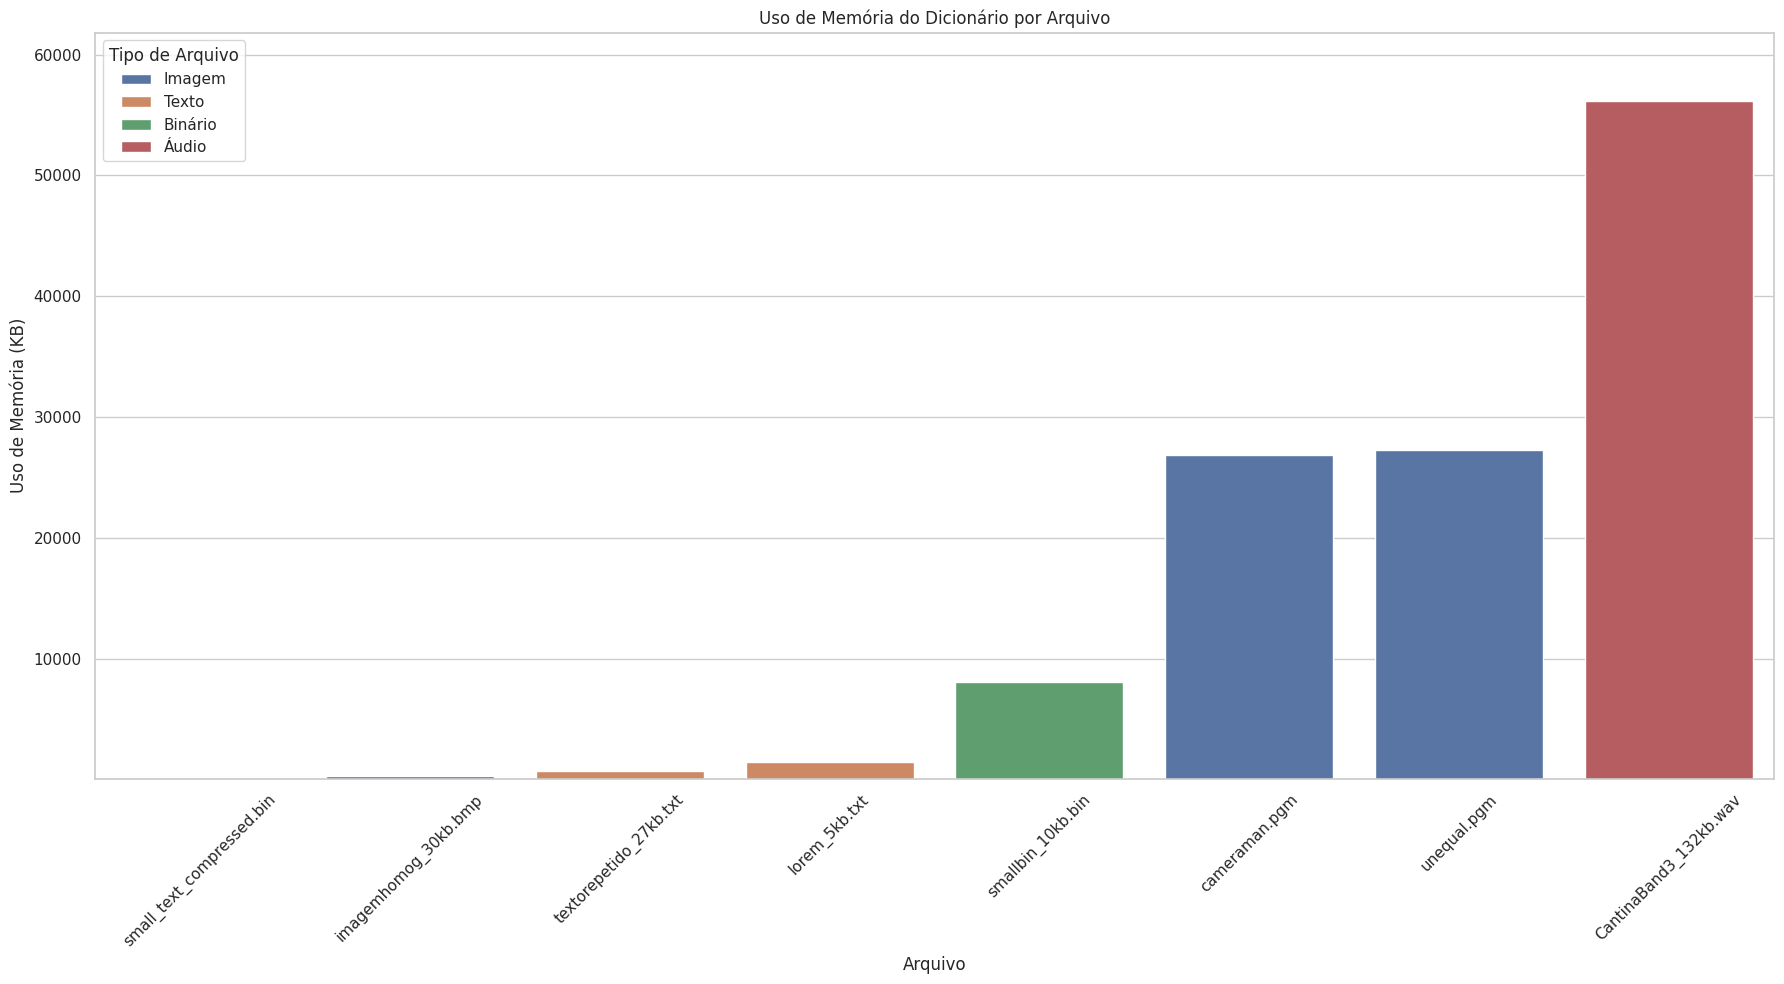

from matplotlib import pyplot as plt
decompression_df['Decompression_Time(s)'].plot(kind='hist', bins=20, title='Decompression_Time(s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
decompression_df.groupby('File_Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
decompression_df.groupby('File_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
decompression_df['Decompression_Time(s)'].plot(kind='line', figsize=(8, 4), title='Decompression_Time(s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['File_Type'].value_counts()
    for x_label, grp in decompression_df.groupby('File_Name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('File_Name')
_ = plt.ylabel('File_Type')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(decompression_df['File_Name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(decompression_df, x='Decompression_Time(s)', y='File_Name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(decompression_df['File_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(decompression_df, x='Decompression_Time(s)', y='File_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [71]:
import subprocess
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import filecmp

# Configurações para melhor visualização dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)  # Aumenta o tamanho padrão das figuras

# Diretório onde os arquivos de teste estão localizados
test_dir = 'test_files'

# Verifica se o diretório 'tests' existe
if not os.path.exists(test_dir):
    print(f"O diretório '{test_dir}' não existe. Por favor, certifique-se de que os arquivos de teste estão na pasta '{test_dir}'.")
    exit(1)

# Lista para armazenar os arquivos que precisam ser processados
files_to_process = []

# Extensões de arquivos a serem considerados
valid_extensions = ['.txt', '.bmp', '.bin', '.pgm', '.wav']

# Percorrer todos os arquivos no diretório 'tests'
for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)
    # Ignorar diretórios
    if os.path.isdir(file_path):
        continue
    # Ignorar arquivos que já foram comprimidos ou descomprimidos
    if filename.endswith('.lzw') or '_decompressed' in filename:
        continue
    # Ignorar arquivos de estatísticas ou outros arquivos não relevantes
    if filename.endswith('_compress_stats.json') or filename.endswith('_decompress_stats.json'):
        continue
    # Verificar se a extensão é válida
    _, ext = os.path.splitext(filename)
    if ext.lower() in valid_extensions:
        files_to_process.append(filename)
    else:
        print(f"Arquivo com extensão não suportada encontrado e será ignorado: {filename}")

# Função para determinar o tipo de arquivo com base na extensão
def get_file_type(extension):
    if extension == '.txt':
        return 'Texto'
    elif extension in ['.bmp', '.pgm']:
        return 'Imagem'
    elif extension == '.wav':
        return 'Áudio'
    elif extension == '.bin':
        return 'Binário'
    else:
        return 'Desconhecido'

# Listas para os dados de Compressão e Descompressão
compression_data = []
decompression_data = []

# Dicionário para armazenar dados de estatísticas detalhadas para cada arquivo
detailed_stats = {}

# Automatizar a Compressão
for filename in files_to_process:
    input_file = os.path.join(test_dir, filename)
    output_file = os.path.join(test_dir, f'{filename}.lzw')
    stats_file = os.path.join(test_dir, f'{filename}_compress_stats.json')

    # Verifica se o arquivo já foi comprimido
    if os.path.exists(output_file):
        print(f"Arquivo comprimido já existe: {output_file}. Pulando a compressão deste arquivo.")
        continue

    command = [
        'python', 'lzw.py', 'compress', input_file, output_file,
        '--max-bits', '12', '--stats-file', stats_file
    ]

    print(f'Compressing {input_file}...')
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Erro ao comprimir {input_file}:")
        print(result.stderr)
    else:
        print(result.stdout)

# Automatizar a Descompressão
for filename in files_to_process:
    input_file = os.path.join(test_dir, f'{filename}.lzw')
    original_extension = os.path.splitext(filename)[1]
    decompressed_filename = f'{os.path.splitext(filename)[0]}_decompressed{original_extension}'
    output_file = os.path.join(test_dir, decompressed_filename)
    stats_file = os.path.join(test_dir, f'{filename}_decompress_stats.json')

    # Verifica se o arquivo comprimido existe
    if not os.path.exists(input_file):
        print(f"Arquivo comprimido não encontrado: {input_file}. Pulando este arquivo.")
        continue

    # Verifica se o arquivo já foi descomprimido
    if os.path.exists(output_file):
        print(f"Arquivo descomprimido já existe: {output_file}. Pulando a descompressão deste arquivo.")
        continue

    command = [
        'python', 'lzw.py', 'decompress', input_file, output_file,
        '--max-bits', '12', '--stats-file', stats_file
    ]

    print(f'Decompressing {input_file}...')
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Erro ao descomprimir {input_file}:")
        print(result.stderr)
    else:
        print(result.stdout)

# Verificar os Arquivos Descomprimidos
for filename in files_to_process:
    original_file = os.path.join(test_dir, filename)
    original_extension = os.path.splitext(filename)[1]
    decompressed_filename = f'{os.path.splitext(filename)[0]}_decompressed{original_extension}'
    decompressed_file = os.path.join(test_dir, decompressed_filename)

    # Verifica se o arquivo descomprimido existe
    if not os.path.exists(decompressed_file):
        print(f"Arquivo descomprimido não encontrado: {decompressed_file}. Pulando verificação deste arquivo.")
        continue

    # Verifica se o arquivo já foi descomprimido corretamente
    if original_extension.lower() in ['.bmp', '.bin', '.pgm', '.wav']:
        files_are_equal = filecmp.cmp(original_file, decompressed_file, shallow=False)
    else:
        # Para arquivos de texto, podemos comparar como strings
        with open(original_file, 'r', encoding='utf-8') as f1, open(decompressed_file, 'r', encoding='utf-8') as f2:
            files_are_equal = f1.read() == f2.read()
    if files_are_equal:
        print(f'{filename} descomprimido com sucesso.')
    else:
        print(f'Erro: {filename} foi descomprimido incorretamente.')

# Coletar Estatísticas de Compressão e Descompressão
for filename in files_to_process:
    # Caminhos para os arquivos de estatísticas
    compress_stats_file = os.path.join(test_dir, f'{filename}_compress_stats.json')
    decompress_stats_file = os.path.join(test_dir, f'{filename}_decompress_stats.json')

    # Determinar o tipo de arquivo com base na extensão
    _, ext = os.path.splitext(filename)
    ftype = get_file_type(ext.lower())

    # Verifica se o arquivo de estatísticas de compressão existe
    if os.path.exists(compress_stats_file):
        with open(compress_stats_file, 'r') as f:
            compress_stats = json.load(f)

        # Calcular a taxa de compressão com base nos tamanhos dos arquivos
        original_file = os.path.join(test_dir, filename)
        compressed_file = os.path.join(test_dir, f'{filename}.lzw')
        if os.path.exists(original_file) and os.path.exists(compressed_file):
            original_size = os.path.getsize(original_file)
            compressed_size = os.path.getsize(compressed_file)
            compression_ratio = compressed_size / original_size if original_size != 0 else None
        else:
            compression_ratio = None

        # Adicionar dados à lista de compressão
        compression_data.append({
            'File_Name': filename,
            'File_Type': ftype,
            'Compression_Ratio': compression_ratio,
            'Dictionary_Size': compress_stats.get('dictionary_size_over_time', [])[-1] if compress_stats.get('dictionary_size_over_time') else None,
            'Compression_Time(s)': compress_stats.get('execution_time', 0),
            'Memory_Usage(KB)': compress_stats.get('memory_usage', 0)
        })

        # Armazenar estatísticas detalhadas para o arquivo
        detailed_stats[filename] = {
            'compression_ratio_over_time': compress_stats.get('compression_ratio_over_time', []),
            'dictionary_size_over_time': compress_stats.get('dictionary_size_over_time', []),
            'memory_usage': compress_stats.get('memory_usage', 0)
        }

    else:
        print(f"Arquivo de estatísticas de compressão não encontrado: {compress_stats_file}")

    # Verifica se o arquivo de estatísticas de descompressão existe
    if os.path.exists(decompress_stats_file):
        with open(decompress_stats_file, 'r') as f:
            decompress_stats = json.load(f)

        # Adicionar dados à lista de descompressão
        decompression_data.append({
            'File_Name': filename,
            'File_Type': ftype,
            'Decompression_Time(s)': decompress_stats.get('execution_time', 0)
        })
    else:
        print(f"Arquivo de estatísticas de descompressão não encontrado: {decompress_stats_file}")

# Criar DataFrames
compression_df = pd.DataFrame(compression_data)
decompression_df = pd.DataFrame(decompression_data)

# Exibir DataFrames
print("Dados de Compressão:")
display(compression_df)

print("Dados de Descompressão:")
display(decompression_df)

# Função para determinar limites globais para escalas consistentes
def get_global_limits(df, column):
    min_val = df[column].min()
    max_val = df[column].max()
    return min_val, max_val

# Obter limites globais para cada métrica
compression_time_min, compression_time_max = get_global_limits(compression_df, 'Compression_Time(s)') if not compression_df.empty else (0, 1)
decompression_time_min, decompression_time_max = get_global_limits(decompression_df, 'Decompression_Time(s)') if not decompression_df.empty else (0, 1)
compression_ratio_min, compression_ratio_max = get_global_limits(compression_df, 'Compression_Ratio') if not compression_df.empty else (0, 1)
memory_usage_min, memory_usage_max = get_global_limits(compression_df, 'Memory_Usage(KB)') if not compression_df.empty else (0, 1)

# Função para ordenar o DataFrame e retornar a ordem dos arquivos
def get_sorted_order(df, y_column):
    sorted_df = df.sort_values(by=y_column)
    return sorted_df['File_Name']

# 1. Gráfico de Tempo de Compressão e Descompressão Ordenados
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Tempo de Compressão
if not compression_df.empty:
    order = get_sorted_order(compression_df, 'Compression_Time(s)')
    sns.barplot(ax=axes[0], x='File_Name', y='Compression_Time(s)', hue='File_Type', data=compression_df, order=order)
    axes[0].set_title('Tempo de Compressão por Arquivo')
    axes[0].set_xlabel('Arquivo')
    axes[0].set_ylabel('Tempo de Compressão (segundos)')
    axes[0].set_ylim(compression_time_min, compression_time_max * 1.1)  # Adiciona 10% para visualização
    axes[0].tick_params(axis='x', rotation=45)
else:
    axes[0].text(0.5, 0.5, 'Nenhum dado de compressão disponível para plotar.', horizontalalignment='center', verticalalignment='center')
    axes[0].set_axis_off()

# Tempo de Descompressão
if not decompression_df.empty:
    order = get_sorted_order(decompression_df, 'Decompression_Time(s)')
    sns.barplot(ax=axes[1], x='File_Name', y='Decompression_Time(s)', hue='File_Type', data=decompression_df, order=order)
    axes[1].set_title('Tempo de Descompressão por Arquivo')
    axes[1].set_xlabel('Arquivo')
    axes[1].set_ylabel('Tempo de Descompressão (segundos)')
    axes[1].set_ylim(decompression_time_min, decompression_time_max * 1.1)
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5, 0.5, 'Nenhum dado de descompressão disponível para plotar.', horizontalalignment='center', verticalalignment='center')
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()

# 2. Gráfico de Taxa de Compressão e Uso de Memória Ordenados
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Taxa de Compressão
if not compression_df.empty:
    order = get_sorted_order(compression_df, 'Compression_Ratio')
    sns.barplot(ax=axes[0], x='File_Name', y='Compression_Ratio', hue='File_Type', data=compression_df, order=order)
    axes[0].set_title('Taxa de Compressão por Arquivo')
    axes[0].set_xlabel('Arquivo')
    axes[0].set_ylabel('Taxa de Compressão (Comprimido / Original)')
    axes[0].set_ylim(compression_ratio_min * 0.9, compression_ratio_max * 1.1)
    axes[0].tick_params(axis='x', rotation=45)
else:
    axes[0].text(0.5, 0.5, 'Nenhum dado de compressão disponível para plotar.', horizontalalignment='center', verticalalignment='center')
    axes[0].set_axis_off()

# Uso de Memória
if not compression_df.empty:
    order = get_sorted_order(compression_df, 'Memory_Usage(KB)')
    sns.barplot(ax=axes[1], x='File_Name', y='Memory_Usage(KB)', hue='File_Type', data=compression_df, order=order)
    axes[1].set_title('Uso de Memória do Dicionário por Arquivo')
    axes[1].set_xlabel('Arquivo')
    axes[1].set_ylabel('Uso de Memória (KB)')
    axes[1].set_ylim(memory_usage_min * 0.9, memory_usage_max * 1.1)
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5, 0.5, 'Nenhum dado de uso de memória disponível para plotar.', horizontalalignment='center', verticalalignment='center')
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()

# 3. Gráficos Detalhados por Arquivo

# Preparar limites globais para os gráficos de Taxa de Compressão e Tamanho do Dicionário
global_compression_ratio_max = max([max(stats['compression_ratio_over_time']) if stats['compression_ratio_over_time'] else 0 for stats in detailed_stats.values()], default=1)
global_dictionary_size_max = max([max(stats['dictionary_size_over_time']) if stats['dictionary_size_over_time'] else 0 for stats in detailed_stats.values()], default=1)

# Plotar Taxa de Compressão ao Longo do Tempo para cada arquivo
for filename in files_to_process:
    if filename in detailed_stats:
        compression_ratio_over_time = detailed_stats[filename]['compression_ratio_over_time']
        if compression_ratio_over_time:
            plt.figure(figsize=(12, 6))
            plt.plot(compression_ratio_over_time)
            plt.title(f'Taxa de Compressão ao Longo do Tempo - {filename}')
            plt.xlabel('Iteração')
            plt.ylabel('Taxa de Compressão')
            plt.ylim(0, global_compression_ratio_max * 1.1)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Sem dados de taxa de compressão ao longo do tempo para {filename}")
    else:
        print(f"Estatísticas detalhadas não encontradas para {filename}")

# Plotar Tamanho do Dicionário ao Longo do Tempo para cada arquivo
for filename in files_to_process:
    if filename in detailed_stats:
        dictionary_size_over_time = detailed_stats[filename]['dictionary_size_over_time']
        if dictionary_size_over_time:
            plt.figure(figsize=(12, 6))
            plt.plot(dictionary_size_over_time, color='orange')
            plt.title(f'Tamanho do Dicionário ao Longo do Tempo - {filename}')
            plt.xlabel('Iteração')
            plt.ylabel('Tamanho do Dicionário')
            plt.ylim(0, global_dictionary_size_max * 1.1)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Sem dados de tamanho do dicionário ao longo do tempo para {filename}")
    else:
        print(f"Estatísticas detalhadas não encontradas para {filename}")

# 4. Gráfico Comparativo do Uso de Memória

# Plotar Uso de Memória do Dicionário por Arquivo Ordenados
if not compression_df.empty:
    # Ordenar os arquivos do menor para o maior uso de memória
    compression_df_sorted_memory = compression_df.sort_values(by='Memory_Usage(KB)')
    order = compression_df_sorted_memory['File_Name']

    plt.figure(figsize=(18, 10))
    sns.barplot(x='File_Name', y='Memory_Usage(KB)', hue='File_Type', data=compression_df, order=order)
    plt.title('Uso de Memória do Dicionário por Arquivo')
    plt.xlabel('Arquivo')
    plt.ylabel('Uso de Memória (KB)')
    plt.ylim(memory_usage_min * 0.9, memory_usage_max * 1.1)
    plt.xticks(rotation=45)
    plt.legend(title='Tipo de Arquivo')
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum dado de uso de memória disponível para plotar.")

# Fazendo a compressão e a descompressão de arquivos usando a classe TrieLZW:

###### Função temporária para verificar se dois arquivos são iguais:

In [ ]:
def are_files_identical(file1, file2):
    """
    Compare two files byte by byte to check if they are identical.
    """
    try:
        with open(file1, "rb") as f1, open(file2, "rb") as f2:
            while True:
                chunk1 = f1.read(4096)  # Read in chunks of 4 KB
                chunk2 = f2.read(4096)
                if chunk1 != chunk2:  # Compare the current chunks
                    return False
                if not chunk1:  # End of file reached
                    return True
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return False

### Exemplo 1 (arquivo de texto)

Gerando artificialmente um texto para teste:

In [ ]:
import random

# Generate the random text
input_data = ''.join(random.choices("abcd", k=100000))

#input_data = 'geekific-geekific'

# Specify the file path
file_path = "test_text.txt"

# Save the text to a .txt file
with open(file_path, "w") as file:
    file.write(input_data)

Aplicando a compressão e a descompressão em sequência:

In [ ]:
teste_trie_lzw = TrieLZW()

file_to_be_compressed = "test_text.txt"

[file_name, file_extension] = teste_trie_lzw.compress(file_to_be_compressed)

compressed_file = f"compressed_{file_name}.bin"

teste_trie_lzw.decompress(compressed_file, file_name, file_extension)

Comparando o tamanho dos arquivos iniciais e finais:

In [ ]:
original_file_size = os.path.getsize(file_to_be_compressed)
compressed_file_size = os.path.getsize(compressed_file)

print(f"Tamanho do arquivo original: {original_file_size} bytes.")
print(f"Tamanho do arquivo comprimido: {compressed_file_size} bytes.")

Verificando se os arquivos são equivalentes:

In [ ]:
txt_file1 = file_to_be_compressed
txt_file2 = f"decompressed_{file_to_be_compressed}"
print(txt_file1)
print(txt_file2)
print(f"Os arquivos .txt são iguais? {are_files_identical(txt_file1, txt_file2)}")

Linha de comando

In [ ]:
# Compressão
!python lzw.py compress test_text.txt compressed_test_text.bin --stats-file compress_stats_test_text.json

# Calcula e imprime os tamanhos dos arquivos original e comprimido
import os
original_file_size = os.path.getsize("test_text.txt")
compressed_file_size = os.path.getsize("compressed_test_text.bin")
print(f"Tamanho do arquivo original: {original_file_size} bytes.")
print(f"Tamanho do arquivo comprimido: {compressed_file_size} bytes.")

In [ ]:
# Descompressão
!python lzw.py decompress compressed_test_text.bin decompressed_test_text.txt --max-bits 16 --stats-file decompress_stats_test_text.json

# Verifica se os arquivos original e descomprimido são iguais
def are_files_identical(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        return f1.read() == f2.read()

txt_file1 = "test_text.txt"
txt_file2 = "decompressed_test_text.txt"
print(f"Os arquivos .txt são iguais? {are_files_identical(txt_file1, txt_file2)}")

### Exemplo 2 (arquivo de imagem)

Gerando artificialmente uma imagem para teste:

In [ ]:
from PIL import Image

# Create a new monochrome (mode '1') image with 10x10 pixels
width, height = 1000, 1000
image = Image.new("1", (width, height))  # Mode "1" means 1-bit pixels (monochrome)

# Set some pixels to black (1 = white, 0 = black)
pixels = image.load()
for x in range(width):
    for y in range(height):
        if (x + y) % 2 == 0:  # Example pattern: checkerboard
            pixels[x, y] = 0  # Black pixel
        else:
            pixels[x, y] = 1  # White pixel

# Save the image as a BMP file
image.save("monochrome_test_image.bmp")

Aplicando a compressão e a descompressão em sequência:

In [ ]:
teste_trie_lzw = TrieLZW()

file_to_be_compressed = "monochrome_test_image.bmp"

[file_name, file_extension] = teste_trie_lzw.compress(file_to_be_compressed)

compressed_file = f"compressed_{file_name}.bin"

teste_trie_lzw.decompress(compressed_file, file_name, file_extension)

Comparando o tamanho dos arquivos iniciais e finais:

In [ ]:
original_file_size = os.path.getsize(file_to_be_compressed)
compressed_file_size = os.path.getsize(compressed_file)

print(f"Tamanho do arquivo original: {original_file_size} bytes.")
print(f"Tamanho do arquivo comprimido: {compressed_file_size} bytes.")

Verificando se os arquivos são equivalentes:

In [ ]:
bmp_file1 = file_to_be_compressed
bmp_file2 = f"decompressed_{file_to_be_compressed}"

print(f"Os arquivos .bmp são iguais? {are_files_identical(bmp_file1, bmp_file2)}")

Linha de comando

In [ ]:
# Compressão
!python lzw.py compress monochrome_test_image.bmp compressed_monochrome_test_image.bin --stats-file compress_stats_monochrome_image.json

# Calcula e imprime os tamanhos dos arquivos original e comprimido
import os
original_file_size = os.path.getsize("monochrome_test_image.bmp")
compressed_file_size = os.path.getsize("compressed_monochrome_test_image.bin")
print(f"Tamanho do arquivo original: {original_file_size} bytes.")
print(f"Tamanho do arquivo comprimido: {compressed_file_size} bytes.")

In [ ]:
# Descompressão
!python lzw.py decompress compressed_monochrome_test_image.bin decompressed_monochrome_test_image.bmp --max-bits 16 --stats-file decompress_stats_monochrome_image.json

# Verifica se os arquivos BMP são iguais
def are_files_identical(file1, file2):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:  # Lê os arquivos como binários
        return f1.read() == f2.read()

bmp_file1 = "monochrome_test_image.bmp"
bmp_file2 = "decompressed_monochrome_test_image.bmp"
print(f"Os arquivos .bmp são iguais? {are_files_identical(bmp_file1, bmp_file2)}")

# Seção provisória para debug

In [ ]:
import struct

def int_to_8bit_binary(number):
  return format(number, '08b')

def remove_leading_zeros(binary_str):
  return binary_str.lstrip('0') or '0'

class LZW:
    def __init__(self):
        self.max_table_size = 4096

    def compress(self, input_data):
        dictionary = {chr(i): i for i in range(256)}
        string = ""
        compressed_data = []

        for symbol in input_data:
            string_plus_symbol = string + symbol
            if string_plus_symbol in dictionary:
                string = string_plus_symbol
            else:
                compressed_data.append(dictionary[string])
                if len(dictionary) < self.max_table_size:
                    dictionary[string_plus_symbol] = len(dictionary)
                string = symbol

        if string in dictionary:
            compressed_data.append(dictionary[string])

        return compressed_data

    def decompress(self, compressed_data):
        dictionary = {chr(i): i for i in range(256)}
        string = chr(compressed_data.pop(0))
        decompressed_data = [string]

        for k in compressed_data:
            print(k)
            if k in dictionary:
                entry = dictionary[k]
            elif k == len(dictionary):
                entry = string + string[0]
            else:
                raise ValueError("Erro na compressão k: %s" % k)

            decompressed_data.append(entry)

            if len(dictionary) < self.max_table_size:
                dictionary[len(dictionary)] = string + entry[0]

            string = entry

        return ''.join(decompressed_data)

In [ ]:
'''
import os
import random

if __name__ == "__main__":
    lzw = LZW()

    input_data = ''.join(random.choices("ab", k=1000))

    input_data = 'geekific-geekific'

    with open("input.txt", 'w') as file:
      file.write(input_data)

    with open("input.txt", "r") as file:
      input_data = file.read()

    with open('input.txt', 'rb') as file:
      input_data_2 = file.read()
      input_data_2 = list(input_data_2)

    compressed_data = lzw.compress(input_data)
    #compressed_data_trie = lzw.compress_trie(input_data_2)
    #integer_compressed_data_trie = [int(binary, 2) for binary in compressed_data_trie]

    #print("A compressão ficou igual!") if compressed_data == integer_compressed_data_trie else print("A compressão ficou diferente!")
    print("Arquivo comprimido (dict):", compressed_data)
    #print("Arquivo comprimido (trie):", integer_compressed_data_trie)
    #print("Arquivo comprimido original (trie):", compressed_data_trie)

    with open("text_compressed_result.txt", 'w') as file:
      final_compressed_string = ''.join(compressed_data_trie)
      file.write(final_compressed_string)

    with open("binary_compressed_result.bin", 'wb') as file:
      final_compressed_string = ''.join(compressed_data_trie)

      padding_size = (8 - len(final_compressed_string) % 8) % 8
      final_compressed_string = '0' * padding_size + final_compressed_string

      file.write(bytes([padding_size]))

      bits = []
      for char in final_compressed_string:
          bits.append(1 if char == '1' else 0)

      byte = 0
      bit_count = 0
      for bit in bits:
          byte = (byte << 1) | bit
          bit_count += 1

          if bit_count == 8:
              file.write(bytes([byte]))
              byte = 0
              bit_count = 0

    size_file1 = os.path.getsize("input.txt")
    size_file2 = os.path.getsize("binary_compressed_result.bin")

    with open("binary_compressed_result.bin", 'rb') as file:
      padding_size = ord(file.read(1))

      data = file.read()

      binary_string = ''.join(format(byte, '08b') for byte in data)

      binary_string = binary_string[padding_size:]

    result = lzw.decompress_trie(binary_string)

    print(" O resultado antes da compressão é: " + input_data)
    print("O resultado após a descompressão é: " + result)
    print(f"Tamanho do arquivo original: {size_file1} bytes")
    print(f"Tamanho do arquivo comprimido: {size_file2} bytes")
    print("O LZW foi bem-sucedido!") if result == input_data else print("O LZW não foi bem-sucedido!")

    with open("compressed_binary.txt", "w") as file:
        binary_data = ' '.join(format(data, '012b') for data in compressed_data)
        file.write(binary_data)

    decompressed_data = lzw.decompress(compressed_data)
    print("Arquivo descomprimido:", decompressed_data)

    with open("decompressed.txt", "w") as file:
        file.write(decompressed_data)
    '''

In [ ]:
'''
import os
from IPython.display import Image
from random import choice
from IPython.display import display, clear_output
import ipywidgets as widgets

trie = CompactTrie()

k = bin(0)[2:]
v = format(0, '08b')

trie.insert(k, v)

file_path = "interactive_trie.png"
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")
trie.visualize("interactive_trie")
display(Image(filename="interactive_trie.png"))
'''

In [ ]:
import os
from IPython.display import Image
from random import choice
from IPython.display import display, clear_output
import ipywidgets as widgets

trie = CompactTrie()
global_counter = 0
delete_input = widgets.Text(description="Delete:")
delete_button = widgets.Button(description="Delete String")

def reset_trie(_):
    global trie, global_counter
    trie = CompactTrie()
    global_counter = 0

    clear_output(wait=True)

    auto_button = widgets.Button(description="Auto")
    auto_button.on_click(random_insert)
    display(auto_button)

def random_insert(_):
    global global_counter
    global_counter += 1
    clear_output(wait=True)

    iterate_button = widgets.Button(description="Next Iteration")
    iterate_button.on_click(random_insert)
    display(iterate_button)

    delete_button.on_click(delete_string)
    display(delete_input)
    display(delete_button)

    reset_button = widgets.Button(description="Reset Trie")
    reset_button.on_click(reset_trie)
    display(reset_button)

    new_node_string = ''.join(choice(['a', 'b']) for _ in range(6))
    print(f"Generated string: {new_node_string}")

    new_binary_string = ''.join('0' if char == 'a' else '1' for char in new_node_string)

    trie.insert(new_binary_string, global_counter)

    file_path = "interactive_trie.png"

    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_path} has been deleted.")
    else:
        print(f"{file_path} does not exist.")

    trie.visualize("interactive_trie")

    display(Image(filename="interactive_trie.png"))

def delete_string(_):
    global delete_input
    binary_string = delete_input.value.strip()
    new_binary_string = ''.join('0' if char == 'a' else '1' for char in binary_string)
    trie.delete_key(new_binary_string)

    clear_output(wait=True)

    iterate_button = widgets.Button(description="Next Iteration")
    iterate_button.on_click(random_insert)
    display(iterate_button)

    delete_button.on_click(delete_string)
    display(delete_input)
    display(delete_button)

    reset_button = widgets.Button(description="Reset Trie")
    reset_button.on_click(reset_trie)
    display(reset_button)

    file_path = "interactive_trie.png"

    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_path} has been deleted.")
    else:
        print(f"{file_path} does not exist.")

    trie.visualize("interactive_trie")

    display(Image(filename="interactive_trie.png"))

auto_button = widgets.Button(description="Auto")
auto_button.on_click(random_insert)
display(auto_button)

In [ ]:
import os
import json

def process_directory(input_directory: str, output_stats_file: str, compressed_dir: str):
    stats = {}
    lzw = TrieLZW()  # Instancia a classe de compressão

    # Garante que o diretório para arquivos comprimidos existe
    os.makedirs(compressed_dir, exist_ok=True)

    for filename in os.listdir(input_directory):
        filepath = os.path.join(input_directory, filename)

        if os.path.isfile(filepath):
            print(f"Processing file: {filename}")

            try:
                # Chama o método de compressão da classe TrieLZW
                file_name, file_extension = lzw.compress(filepath)

                # Caminho original gerado pelo método compress
                compressed_file = f"compressed_{file_name}.bin"

                # Se o arquivo já foi salvo em compressed_dir, não é necessário mover
                original_compressed_path = os.path.join(os.getcwd(), compressed_file)
                if not os.path.exists(original_compressed_path):
                    original_compressed_path = os.path.join(compressed_dir, compressed_file)

                # Verifica se o arquivo existe e move para o diretório correto
                if os.path.exists(original_compressed_path):
                    new_compressed_path = os.path.join(compressed_dir, compressed_file)
                    os.rename(original_compressed_path, new_compressed_path)
                else:
                    print(f"Compressed file not found: {compressed_file}")

                # Armazena as estatísticas para o arquivo processado
                stats[filename] = {
                    "compression_ratio_over_time": lzw.stats['compression_ratio_over_time'],
                    "dictionary_size_over_time": lzw.stats['dictionary_size_over_time'],
                    "execution_time": lzw.stats['execution_time'],
                    "memory_usage": lzw.stats['memory_usage']
                }
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Salva as estatísticas em um arquivo JSON
    with open(output_stats_file, 'w', encoding='utf-8') as stats_file:
        json.dump(stats, stats_file, indent=4)

    print(f"Statistics saved to {output_stats_file}")

# Configuração do diretório de entrada e saída
input_directory = "tests"  # Substitua pelo caminho do seu diretório de testes
compressed_directory = "compressed_tests"  # Diretório para salvar os arquivos comprimidos
output_file = "statistics.json"

process_directory(input_directory, output_file, compressed_directory)

# Relatório